In [400]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/diogo/programs/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['display']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [401]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import obspy as op
import glob
import os
import fnmatch
import shutil
import matplotlib.gridspec as gridspec
from scipy import signal,stats,spatial,misc
from obspy.taup import TauPyModel
import time
from IPython import display
import matplotlib.gridspec as gridspec
from obspy.clients.fdsn import Client
from obspy.clients.iris import Client as OldIris_Client
from obspy.core.util import NamedTemporaryFile
import matplotlib.mlab as mlab
import itertools
from obspy import UTCDateTime
from matplotlib.cbook import get_sample_data
from mpl_toolkits.basemap import Basemap
from matplotlib.ticker import FormatStrFormatter


<h2 align="center">Estações Sismográficas</h2>

In [402]:
STA = ['BDCO','BPPF','BUCO','GENI','GRJU','PRDT','STSN','STSR','TRZN']

BDCO = 0, BPPF = 1 ,BUCO = 2, GENI = 3, GRJU = 4, PRDT = 5, STSN = 6, STSR = 7, TRZN = 8

In [403]:
z = 1

<h2 align="center">Recolhendo as listas com os grupos de BAZ das Funções do Receptor</h2>

In [404]:
RF_list_BAZ = []
RF_list_BAZS = []

for root, dirs, files in os.walk('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/joint_inversion/JI_10_25/'+STA[z]):
    for datafile in files:
        if datafile.startswith('urayl.sac'):
            RF_list_BAZ.append(os.path.join(root, datafile))
RF_list_BAZS = sorted(RF_list_BAZ)

In [405]:
JI_folder_list = []
JI_BAZ_list = []
JI_BAZ = [] 
JI_folder_list = [i.split('urayl')[0] for i in RF_list_BAZS]
JI_BAZ_list = [i.split('/')[10] for i in JI_folder_list]
JI_BAZ = [i.split('BAZ_')[1] for i in JI_BAZ_list]

<h2 align="center">Transformando os arquivos das pastas para poder Plotar a Inversão Conjunta</h2>

In [406]:
for i,j in enumerate(JI_folder_list):
    os.chdir(j)
    os.system('sac2xy 2 model.0.vs > model_0_vs.txt')
    os.system('sac2xy 2 model.9.vs > model_9_vs.txt')
    os.system('sac2xy 2 syn.9ur.disp > syn_9ur.txt')
    os.system('sac2xy 2 urayl.sac > urayl.txt')

In [407]:
model_joint_0 = [[] for x in range(len(JI_folder_list))]
model_joint_9 = [[] for x in range(len(JI_folder_list))]

for i,j in enumerate(JI_folder_list):
    with open(j+'model_0_vs.txt') as inputfile:
        for line in inputfile:
            model_joint_0[i].append(line.strip().split())
            
for i,j in enumerate(JI_folder_list):
    with open(j+'model_9_vs.txt') as inputfile:
        for line in inputfile:
            model_joint_9[i].append(line.strip().split())
            
vs_9 = [[] for x in range(len(JI_folder_list))]
prof_9 = [[] for x in range(len(JI_folder_list))]

for i,j in enumerate(model_joint_9):
    for k,l in enumerate(j):
        vs_9[i].append(float(l[0]))
        prof_9[i].append(float(l[1]))

vs_0 = [[] for x in range(len(JI_folder_list))]
prof_0 = [[] for x in range(len(JI_folder_list))]
for i,j in enumerate(model_joint_0):
    for k,l in enumerate(j):
        vs_0[i].append(float(l[0]))
        prof_0[i].append(float(l[1]))

In [408]:
RF_0_10 = [[] for x in range(len(JI_folder_list))]
RF_10 = [[] for x in range(len(JI_folder_list))]

for i,j in enumerate(JI_folder_list):
    if os.path.isfile(j+'syn.9lf'+JI_BAZ[i]+'.rftn') == True:        
        RF_0_10[i] = op.read(j+'rftn_lf'+JI_BAZ[i]+'.'+STA[z])
        RF_10[i] = op.read(j+'syn.9lf'+JI_BAZ[i]+'.rftn')
    else:
        RF_0_10[i] = []
        RF_10[i] = []

In [409]:
RF_0_25 = [[] for x in range(len(JI_folder_list))]
RF_25 = [[] for x in range(len(JI_folder_list))]


for i,j in enumerate(JI_folder_list):
    if os.path.isfile(j+'syn.9hf'+JI_BAZ[i]+'.rftn') == True:        
        RF_0_25[i] = op.read(j+'rftn_hf'+JI_BAZ[i]+'.'+STA[z])
        RF_25[i] = op.read(j+'syn.9hf'+JI_BAZ[i]+'.rftn')
    else:
        RF_0_25[i] = []
        RF_25[i] = []

In [410]:
model_joint_0_vg_per = [[] for x in range(len(JI_folder_list))]
model_joint_9_vg_per = [[] for x in range(len(JI_folder_list))]

group_ray_periods_0 = [[] for x in range(len(JI_folder_list))]
group_ray_amp_0 = [[] for x in range(len(JI_folder_list))]

group_ray_periods_9 = [[] for x in range(len(JI_folder_list))]
group_ray_amp_9 = [[] for x in range(len(JI_folder_list))]

for i,j in enumerate(JI_folder_list):
    with open(j+'urayl.txt') as inputfile:
        for line in inputfile:
            model_joint_0_vg_per[i].append(line.strip().split())
            
for i,j in enumerate(JI_folder_list):
    with open(j+'syn_9ur.txt') as inputfile:
        for line in inputfile:
            model_joint_9_vg_per[i].append(line.strip().split())

for i,j in enumerate(model_joint_0_vg_per):
    for k,l in enumerate(j):
        group_ray_periods_0[i].append(float(l[0]))
        group_ray_amp_0[i].append(float(l[1]))

for i,j in enumerate(model_joint_9_vg_per):
    for k,l in enumerate(j):
        group_ray_periods_9[i].append(float(l[0]))
        group_ray_amp_9[i].append(float(l[1]))

In [411]:
num_RF_10 = [[] for x in range(len(JI_folder_list))]

BAZ_10 = [[] for x in range(len(JI_folder_list))]
BAZ_10_error = [[] for x in range(len(JI_folder_list))]

RP_10 = [[] for x in range(len(JI_folder_list))]
RP_10_error = [[] for x in range(len(JI_folder_list))]

for i,j in enumerate(JI_folder_list):
    if os.path.isfile('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/joint_inversion/gcarc_30_1.0/'+STA[z]+'/'+'BAZ_'+JI_BAZ[i]+'/'+'BP_'+STA[z]+'_stacking_mean_std_10.txt') == True:        
        num_RF_10[i] = np.genfromtxt('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/joint_inversion/gcarc_30_1.0/'+STA[z]+'/'+'BAZ_'+JI_BAZ[i]+'/'+'BP_'+STA[z]+'_stacking_mean_std_10.txt')[0]
        BAZ_10[i] = np.genfromtxt('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/joint_inversion/gcarc_30_1.0/'+STA[z]+'/'+'BAZ_'+JI_BAZ[i]+'/'+'BP_'+STA[z]+'_stacking_mean_std_10.txt')[1]
        BAZ_10_error[i] = np.genfromtxt('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/joint_inversion/gcarc_30_1.0/'+STA[z]+'/'+'BAZ_'+JI_BAZ[i]+'/'+'BP_'+STA[z]+'_stacking_mean_std_10.txt')[2]
        RP_10[i] = np.genfromtxt('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/joint_inversion/gcarc_30_1.0/'+STA[z]+'/'+'BAZ_'+JI_BAZ[i]+'/'+'BP_'+STA[z]+'_stacking_mean_std_10.txt')[3]
        RP_10_error[i] = np.genfromtxt('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/joint_inversion/gcarc_30_1.0/'+STA[z]+'/'+'BAZ_'+JI_BAZ[i]+'/'+'BP_'+STA[z]+'_stacking_mean_std_10.txt')[4]   
    else:
        num_RF_10[i] = 0
        BAZ_10[i] = []
        BAZ_10_error[i] = []
        RP_10[i] = []
        RP_10_error[i] = []


In [412]:
num_RF_25 = [[] for x in range(len(JI_folder_list))]

BAZ_25 = [[] for x in range(len(JI_folder_list))]
BAZ_25_error = [[] for x in range(len(JI_folder_list))]

RP_25 = [[] for x in range(len(JI_folder_list))]
RP_25_error = [[] for x in range(len(JI_folder_list))]


for i,j in enumerate(JI_folder_list):
    if os.path.isfile('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/joint_inversion/gcarc_30_2.5/'+STA[z]+'/'+'BAZ_'+JI_BAZ[i]+'/'+'BP_'+STA[z]+'_stacking_mean_std_25.txt') == True:        
        num_RF_25[i] = np.genfromtxt('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/joint_inversion/gcarc_30_2.5/'+STA[z]+'/'+'BAZ_'+JI_BAZ[i]+'/'+'BP_'+STA[z]+'_stacking_mean_std_25.txt')[0]
        BAZ_25[i] = np.genfromtxt('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/joint_inversion/gcarc_30_2.5/'+STA[z]+'/'+'BAZ_'+JI_BAZ[i]+'/'+'BP_'+STA[z]+'_stacking_mean_std_25.txt')[1]
        BAZ_25_error[i] = np.genfromtxt('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/joint_inversion/gcarc_30_2.5/'+STA[z]+'/'+'BAZ_'+JI_BAZ[i]+'/'+'BP_'+STA[z]+'_stacking_mean_std_25.txt')[2]
        RP_25[i] = np.genfromtxt('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/joint_inversion/gcarc_30_2.5/'+STA[z]+'/'+'BAZ_'+JI_BAZ[i]+'/'+'BP_'+STA[z]+'_stacking_mean_std_25.txt')[3]
        RP_25_error[i] = np.genfromtxt('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/joint_inversion/gcarc_30_2.5/'+STA[z]+'/'+'BAZ_'+JI_BAZ[i]+'/'+'BP_'+STA[z]+'_stacking_mean_std_25.txt')[4]
    else:
        num_RF_25[i] = 0
        BAZ_25[i] = []
        BAZ_25_error[i] = []
        RP_25[i] = []
        RP_25_error[i] = []

<h2 align="center">Calculando o erro da inversão conjunta para cada estação</h2>

In [413]:
peso = []
for i,j in enumerate(num_RF_10):
    if num_RF_10[i] == []:        
        peso.append(num_RF_25[i])
    elif num_RF_25 == []:
        peso.append(num_RF_10[i])
    else:
        peso.append(j+num_RF_25[i])

In [414]:
peso = []
for i,j in enumerate(num_RF_10):
    if num_RF_25[i] == []:        
        peso.append(num_RF_10[i])
    elif num_RF_10 == []:
        peso.append(num_RF_25[i])
    else:
        peso.append(j+num_RF_25[i])

In [415]:
peso_sum = sum(peso)

In [416]:
vs_media = np.average(vs_9, axis=0,weights=peso)
prof_media = prof_9[0]

In [417]:
vs_media = np.average(vs_9, axis=0,weights=peso)

In [418]:
vs_error = [[] for x in range(len(JI_folder_list))]
for i,j in enumerate(vs_9):
    vs_error[i].append(j-vs_media)

In [419]:
vs_error_std = [[] for x in range(len(JI_folder_list))]
for i,j in enumerate(vs_error):
    vs_error_std[i].append(2*np.std(j))

In [420]:
vs_error_std_sta = 2*np.mean(vs_error_std)

<h2 align="center">Calculando o erro da profundidade de Moho para cada estação</h2>

In [421]:
Moho_JI_index = [[] for x in range(len(JI_folder_list))]
vs_Moho_JI = [[] for x in range(len(JI_folder_list))]
for i,j in enumerate(vs_9):
    Moho_JI_index[i].append(min(enumerate(j[:40]), key=lambda x: abs(x[1]-4.3))[0])
    vs_Moho_JI[i].append(min(enumerate(j[:40]), key=lambda x: abs(x[1]-4.3))[1])

In [422]:
Moho_JI = [[] for x in range(len(JI_folder_list))]
for i,j in enumerate(prof_9):
    if vs_Moho_JI[i][0] > 4.3:
        Moho_JI[i].append(j[Moho_JI_index[i][0]])
    else:
        Moho_JI[i].append(j[Moho_JI_index[i][0]+1])

In [423]:
Moho_JI_media = np.average(Moho_JI, axis=0,weights=peso)

In [424]:
Moho_JI_error1 = [[] for x in range(len(JI_folder_list))]
for i,j in enumerate(Moho_JI):
    Moho_JI_error1[i].append(Moho_JI_media-j)

In [425]:
Moho_JI_error = []
for i,j in enumerate(Moho_JI_error1):
    Moho_JI_error.append(j[0][0])

In [426]:
Moho_JI_std = 2*np.std(Moho_JI_error)

In [427]:
Moho_JI_error

[1.764705882352942, -0.73529411764705799, -0.73529411764705799]

In [428]:
Moho_JI_error_media = np.average(Moho_JI_error, axis=0)

In [429]:
Moho_JI_media

array([-40.23529412])

In [430]:
np.savetxt('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/joint_inversion/JI_10_25/'+STA[z]+'/'+STA[z]+'_JI_moho_error.txt',np.c_[Moho_JI_media[0]*-1,Moho_JI_error_media])

<h2 align="center">Plotando os modelos de velocidade para cada Grupo de Back azimuth</h2>

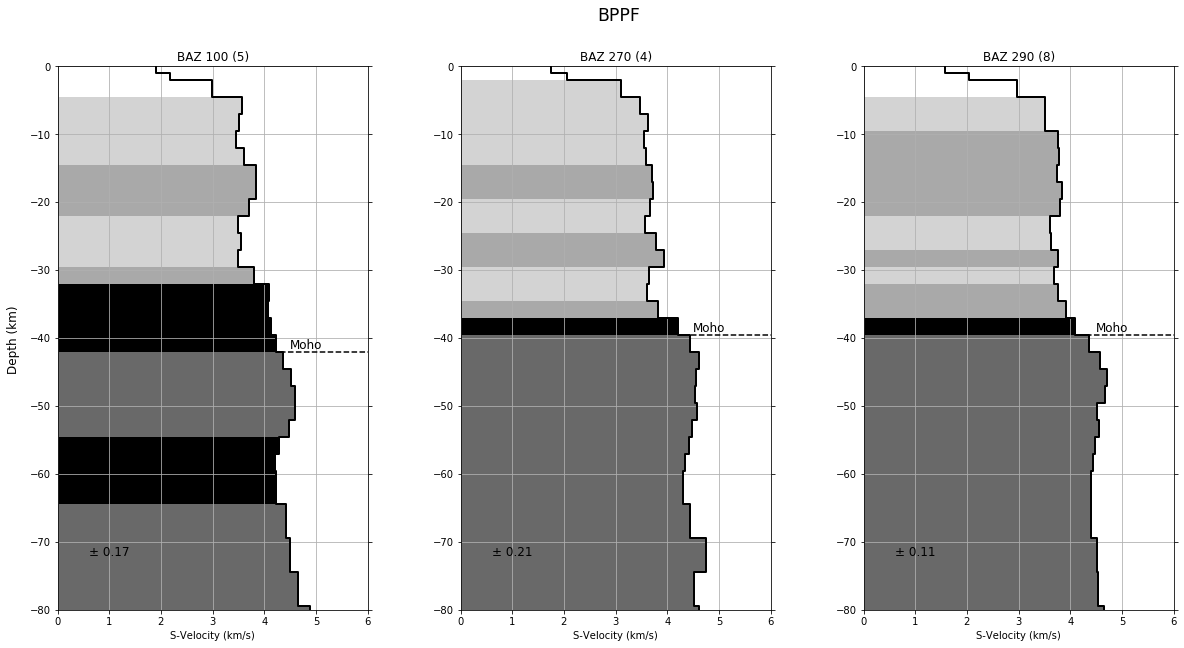

In [431]:
fig = plt.figure(figsize=(20,10),facecolor='white')
gs1 = gridspec.GridSpec(1,len(JI_folder_list),wspace=0.3, hspace=0.3)

for i,j in enumerate(JI_folder_list):
    ax1 = fig.add_subplot(gs1[i])
    ax1.fill_betweenx(prof_9[i],0,vs_9[i],where=[round(i,2) <3.0 for i in vs_9[i]],facecolor='w')
    ax1.fill_betweenx(prof_9[i],0,vs_9[i],where=[round(i,2) >=3.0 and round(i,2) <3.7 for i in vs_9[i]],facecolor='lightgray')
    ax1.fill_betweenx(prof_9[i],0,vs_9[i],where=[round(i,2) >=3.7 and round(i,2) <4.0 for i in vs_9[i]],facecolor='darkgray')
    ax1.fill_betweenx(prof_9[i],0,vs_9[i],where=[round(i,2) >=4.0 and round(i,2) <4.3 for i in vs_9[i]],facecolor='k')
    ax1.fill_betweenx(prof_9[i],0,vs_9[i],where=[round(i,2) >=4.3 for i in vs_9[i]],facecolor='dimgrey')
    #ax1.step(vs_0[i],prof_0[i],'grey',lw= 2, where='post',label='Initial Model')
    ax1.step(vs_9[i],prof_9[i],'k',lw= 2, where='post',label='Final Model')
    plt.tick_params(top='off', bottom='on', left='on', right='on')
    ax1.text(0.1,0.1,'\xb1 '+str("{0:.2f}".format(*vs_error_std[i])), transform=ax1.transAxes, fontsize=12)
    ax1.set_title('BAZ '+JI_BAZ[i]+' ('+str("{0:.0f}".format(peso[i]))+')' )
    ax1.hlines(Moho_JI[i][0], 4.3, 6, colors='k', linestyles='dashed')
    ax1.annotate('Moho', xy=(4.5, Moho_JI[i][0]+0.5), fontsize=12)
    #ax1.set_aspect(0.3)
    ax1.set_xlim([0,6])
    ax1.set_ylim([-80,-0.0])
    ax1.set_xlabel('S-Velocity (km/s)')
    ax1.axes.grid('on') 
    np.savetxt('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/joint_inversion/JI_10_25/'+STA[z]+'/'+STA[z]+'_'+JI_BAZ[i]+'_velocity_model_BAZ.txt',np.c_[vs_9[i],prof_9[i]])
fig.text(0.09, 0.5, 'Depth (km)', va='center', rotation='vertical',fontsize='large')
fig.text(0.5, 0.95, STA[z], va='center', fontsize='xx-large')
fig.savefig('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/joint_inversion/JI_10_25/'+STA[z]+'/joint_inversion_models.pdf')


In [432]:
np.savetxt('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/joint_inversion/JI_10_25/'+STA[z]+'/'+STA[z]+'_mean_velocity_model.txt',np.c_[vs_media,prof_media])
np.savetxt('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/joint_inversion/JI_10_25/'+STA[z]+'/'+STA[z]+'_initial_velocity_model.txt',np.c_[vs_0[0],prof_0[0]])

<h2 align="center">Plotando a inversão conjunta entre as Funções do Receptor e as Curvas de Dispersão</h2>

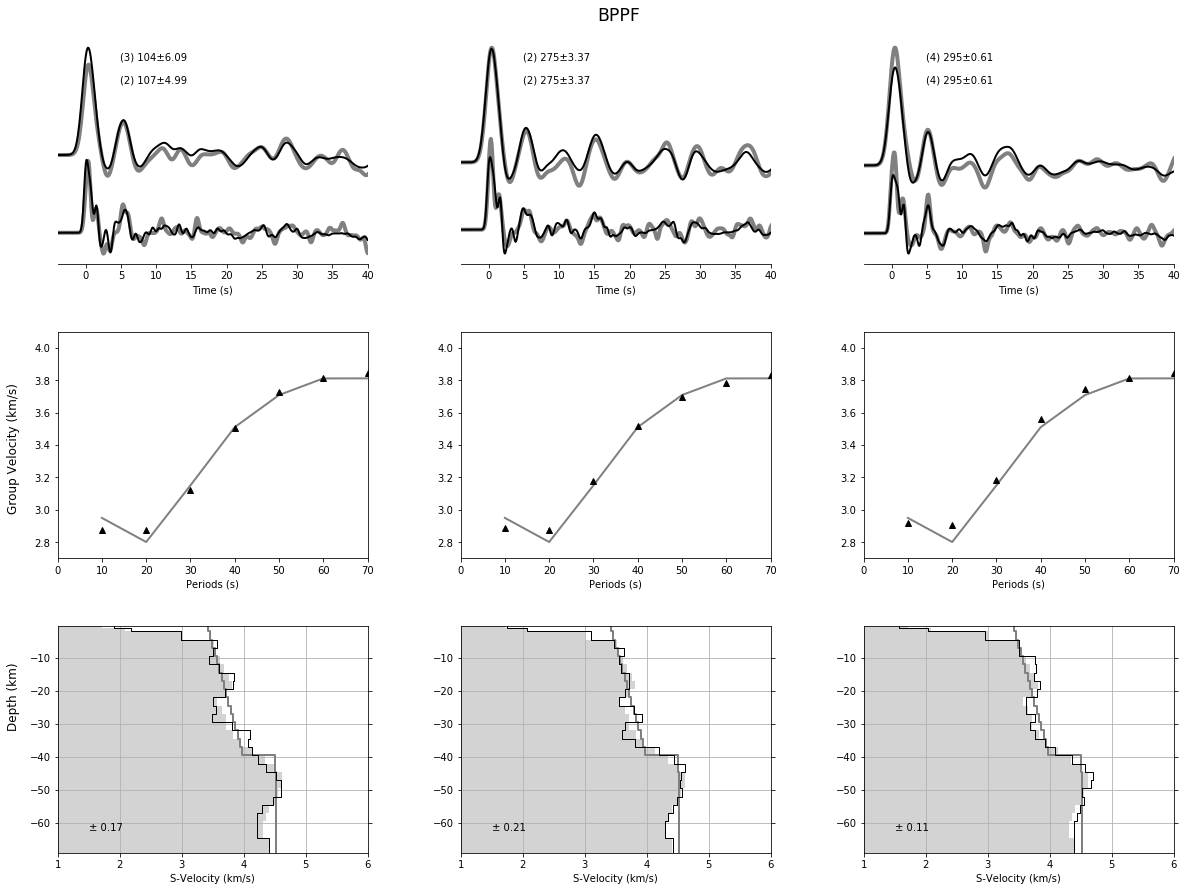

In [433]:
fig = plt.figure(figsize=(20,15),facecolor='white')
gs1 = gridspec.GridSpec(3,len(JI_folder_list),wspace=0.3, hspace=0.3)

for i,j in enumerate(JI_folder_list):
    if RF_0_25[i] != []:
        ax4 = fig.add_subplot(gs1[0,i])
        ax4.plot(RF_0_25[i][0].times()-10,1.5*RF_0_25[i][0].data,'grey',lw=4,label='Observed')
        ax4.plot(RF_25[i][0].times()-10,1.5*RF_25[i][0].data,'k',lw=2,label='Predicted')
        ax4.set_xlim(-4,40)
        ax4.set_xlabel('Time (s)')
        ax4.set_yticks([])
        ax4.spines['right'].set_visible(False)
        ax4.spines['left'].set_visible(False)
        ax4.spines['top'].set_visible(False)
        if str("{0:.0f}".format(num_RF_25[i])) != '1':        
            ax4.text(0.2, 0.80, '('+str("{0:.0f}".format(num_RF_25[i]))+') '+str("{0:.0f}".format(BAZ_25[i]))+str('\xb1')+str("{0:.2f}".format(BAZ_25_error[i])), transform=ax4.transAxes, fontsize=10)
        else:
            ax4.text(0.2, 0.80, '('+str("{0:.0f}".format(num_RF_25[i]))+') '+str("{0:.0f}".format(BAZ_25[i])), transform=ax4.transAxes, fontsize=10)

        
    if RF_0_10[i] != []:        
        ax4 = fig.add_subplot(gs1[0,i])
        ax4.plot(RF_0_10[i][0].times()-10,0.5+1.5*RF_0_10[i][0].data,'grey',lw=4,label='Observed')
        ax4.plot(RF_10[i][0].times()-10,0.5+1.5*RF_10[i][0].data,'k',lw=2,label='Predicted')
        ax4.set_xlim(-4,40)
        ax4.set_xlabel('Time (s)')
        ax4.set_yticks([])
        ax4.spines['right'].set_visible(False)
        ax4.spines['left'].set_visible(False)
        ax4.spines['top'].set_visible(False)
        if str("{0:.0f}".format(num_RF_10[i])) != '1':        
            ax4.text(0.2, 0.90, '('+str("{0:.0f}".format(num_RF_10[i]))+') '+str("{0:.0f}".format(BAZ_10[i]))+str('\xb1')+str("{0:.2f}".format(BAZ_10_error[i])), transform=ax4.transAxes, fontsize=10)
        else:
            ax4.text(0.2, 0.90, '('+str("{0:.0f}".format(num_RF_10[i]))+') '+str("{0:.0f}".format(BAZ_10[i])), transform=ax4.transAxes, fontsize=10)
            



    ax5 = fig.add_subplot(gs1[1,i])
    ax5.plot(group_ray_periods_0[i],group_ray_amp_0[i],'grey',lw=2,label='Observed')
    ax5.plot(group_ray_periods_9[i],group_ray_amp_9[i],'^k',lw=1,label='Predicted')
    ax5.set_xlim(0,70)
    ax5.set_ylim(2.7,4.1)
    ax5.set_xlabel('Periods (s)')
    ax5.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax5.get_yaxis().set_tick_params(which='both', direction='out')
    
    ax1 = fig.add_subplot(gs1[2,i])
    ax1.fill_betweenx(prof_media,0,vs_media,where=[i >=0 and i <=5 for i in vs_media],facecolor='lightgray')
    ax1.step(vs_0[i],prof_0[i],'grey',lw= 2, where='post',label='Initial Model')
    ax1.step(vs_9[i],prof_9[i],'k',lw= 1, where='post',label='Final Model')
    plt.tick_params(top='off', bottom='on', left='on', right='on')
    ax1.text(0.1,0.1,'\xb1 '+str("{0:.2f}".format(*vs_error_std[i])), transform=ax1.transAxes, fontsize=10)
    ax1.set_xlim([1,6])
    ax1.set_ylim([-69,-0.5])
    ax1.set_xlabel('S-Velocity (km/s)')
    ax1.axes.grid('on') 


#    ax1.legend(loc=3)
fig.text(0.09, 0.27, 'Depth (km)', va='center', rotation='vertical',fontsize='large')
fig.text(0.09, 0.5, 'Group Velocity (km/s)', va='center', rotation='vertical',fontsize='large')
fig.text(0.5, 0.9, STA[z], va='center', fontsize='xx-large')


fig.savefig('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/joint_inversion/JI_10_25/'+STA[z]+'/joint_inversion_BAZ.pdf')

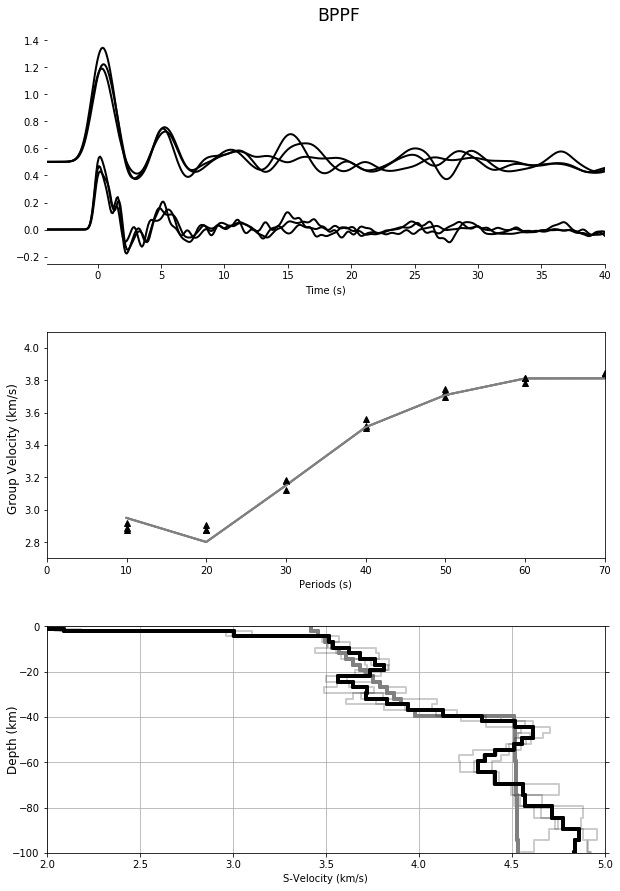

In [434]:
fig = plt.figure(figsize=(10,15),facecolor='white')
gs1 = gridspec.GridSpec(3,1,wspace=0.3, hspace=0.3)

for i,j in enumerate(JI_folder_list):
    ax4 = fig.add_subplot(gs1[0])
    #ax4.plot(RF_0_25[i][0].times()-10,1.5*RF_0_25[i][0].data,'grey',lw=4,label='Observed',alpha=0.7)

    if RF_0_25[i] != []:
        ax4.plot(RF_25[i][0].times()-10,1.5*RF_25[i][0].data,'k',lw=2,label='Predicted')
        ax4.set_xlim(-4,40)
        ax4.set_xlabel('Time (s)')
        #ax4.set_yticks([])
        ax4.spines['right'].set_visible(False)
        ax4.spines['left'].set_visible(False)
        ax4.spines['top'].set_visible(False)
       
    ax4 = fig.add_subplot(gs1[0])
    #ax4.plot(RF_0_10[i][0].times()-10,0.5+1.5*RF_0_10[i][0].data,'grey',lw=4,label='Observed',alpha=0.7)
    if RF_0_10[i] != []:        
        ax4.plot(RF_10[i][0].times()-10,0.5+1.5*RF_10[i][0].data,'k',lw=2,label='Predicted')
        ax4.set_xlim(-4,40)
        ax4.set_xlabel('Time (s)')
        #ax4.set_yticks([])
        ax4.spines['right'].set_visible(False)
        ax4.spines['left'].set_visible(False)
        ax4.spines['top'].set_visible(False)
       
    ax5 = fig.add_subplot(gs1[1])
    ax5.plot(group_ray_periods_0[i],group_ray_amp_0[i],'grey',lw=2,label='Observed')
    ax5.plot(group_ray_periods_9[i],group_ray_amp_9[i],'^k',lw=1,label='Predicted')
    ax5.set_xlim(0,70)
    ax5.set_ylim(2.7,4.1)
    ax5.set_xlabel('Periods (s)')
    ax5.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax5.get_yaxis().set_tick_params(which='both', direction='out')
    
    ax1 = fig.add_subplot(gs1[2])
    #ax1.fill_betweenx(prof_media,0,vs_media,where=[i >=0 and i <=5 for i in vs_media],facecolor='lightgray')
    ax1.step(vs_0[i],prof_0[i],'grey',lw= 4, where='post',label='Initial Model')
    ax1.step(vs_9[i],prof_9[i],'k',lw= 2, where='post',label='Final Model',alpha=0.2)
    ax1.step(vs_media,prof_media,'k',lw= 4, where='post',label='Final Model')
    plt.tick_params(top='off', bottom='on', left='on', right='on')
    ax1.set_xlim([2,5])
    ax1.set_ylim([-100,0])
    ax1.set_xlabel('S-Velocity (km/s)')
    ax1.axes.grid('on') 


#    ax1.legend(loc=3)
fig.text(0.07, 0.23, 'Depth (km)', va='center', rotation='vertical',fontsize='large')
fig.text(0.07, 0.5, 'Group Velocity (km/s)', va='center', rotation='vertical',fontsize='large')
fig.text(0.5, 0.9, STA[z], va='center', fontsize='xx-large')


fig.savefig('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/joint_inversion/JI_10_25/'+STA[z]+'/joint_inversion.pdf')